# Name Classification with RNN
Based on [Patrick Loeber](https://www.youtube.com/@patloeber)'s [Tutorial](https://www.youtube.com/watch?v=WEV61GmmPrk)

### Downloads and Imports

In [ ]:
%%shell
wget -N https://download.pytorch.org/tutorial/data.zip
unzip -u data.zip

--2023-09-04 19:48:06--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 18.160.10.76, 18.160.10.36, 18.160.10.22, ...
Connecting to download.pytorch.org (download.pytorch.org)|18.160.10.76|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘data.zip’ not modified on server. Omitting download.

Archive:  data.zip


In [ ]:
import string
import unicodedata
import io
import os
import glob
import torch
import random
import torch.nn as nn
import matplotlib.pyplot as plt

## Code

### Utils

In [ ]:
ALL_LETTERS = string.ascii_letters + " .,;'"
N_LETTERS = len(ALL_LETTERS)
ALL_LETTERS, N_LETTERS

("abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'", 57)

In [ ]:
# Turn unicode string to ASCII

def unicode_to_ascii(s):
  return "".join(
      c for c in unicodedata.normalize("NFD", s)
      if unicodedata.category(c) != "Mn"
      and c in ALL_LETTERS
  )

In [ ]:
unicode_to_ascii("pretérito")

'preterito'

In [ ]:
# path = 'data/names/*.txt'
def load_data(path):
  category_lines = {}
  all_categories = []

  # Glob
  def find_files(files_path):
    return glob.glob(files_path)

  # Read a file and split into lined
  def read_lines(filename):
    lines = io.open(filename, encoding="utf-8").read().strip().split("\n")
    return [unicode_to_ascii(line) for line in lines]

  for filename in find_files(path):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)

    lines = read_lines(filename)
    category_lines[category] = lines

  return category_lines, all_categories

In [ ]:
path = 'data/names/*.txt'
load_data(path)[1]

['Spanish',
 'Chinese',
 'German',
 'Vietnamese',
 'Czech',
 'Japanese',
 'Irish',
 'Russian',
 'Greek',
 'French',
 'Korean',
 'Italian',
 'English',
 'Arabic',
 'Polish',
 'Portuguese',
 'Scottish',
 'Dutch']

In [ ]:
def letter_to_index(letter):
  return ALL_LETTERS.find(letter)

In [ ]:
letter_to_index("P")

41

In [ ]:
def letter_to_tensor(letter):
  tensor = torch.zeros(1, N_LETTERS)
  tensor[0][letter_to_index(letter)] = 1
  return tensor

In [ ]:
letter_to_tensor("P")

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])

In [ ]:
def line_to_tensor(line):
  tensor = torch.zeros(len(line), 1, N_LETTERS)
  for i, letter in enumerate(line):
    tensor[i][0][letter_to_index(letter)] = 1
  return tensor

In [ ]:
line_to_tensor("Pedro")

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0

In [ ]:
def random_training_example(category_lines, all_categories):
  def random_choice(a):
    random_idx = random.randint(0, len(a) -1)
    return a[random_idx]

  category = random_choice(all_categories)
  line = random_choice(category_lines[category])
  category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
  line_tensor = line_to_tensor(line)

  return category, line, category_tensor, line_tensor

In [ ]:
category_lines, all_categories = load_data(path)
random_training_example(category_lines, all_categories)

('English',
 'Perrett',
 tensor([12]),
 tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0.]],
 
         [[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0.]],
 
         [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0.]],
 
         [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [ ]:
print(ALL_LETTERS)
print(unicode_to_ascii('Ślusàrski'))

category_lines, all_categories = load_data(path)
print(category_lines['Italian'][:5])

print(letter_to_tensor('J'))
print(line_to_tensor('Jones').size())

abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'
Slusarski
['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


### RNN

In [ ]:
class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(RNN, self).__init__()

    self.hidden_size = hidden_size
    self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
    self.i2o = nn.Linear(input_size + hidden_size, output_size)
    self.softmax = nn.LogSoftmax(dim=1)

  def forward(self, input_tensor, hidden_tensor):
    combined = torch.cat((input_tensor, hidden_tensor), 1)

    hidden = self.i2h(combined)
    output = self.i2o(combined)
    output = self.softmax(output)

    return output, hidden

  def init_hidden(self):
    return torch.zeros(1, self.hidden_size)

In [ ]:
category_lines, all_categories = load_data(path)
n_categories = len(all_categories)
n_categories

18

In [ ]:
n_hidden = 128

In [ ]:
rnn = RNN(N_LETTERS, n_hidden, n_categories)

One Step

In [ ]:
input_tensor = letter_to_tensor("P")
hidden_tensor = rnn.init_hidden()

In [ ]:
output, next_hidden = rnn.forward(input_tensor, hidden_tensor)

In [ ]:
output.size(), next_hidden.size()

(torch.Size([1, 18]), torch.Size([1, 128]))

Whole Sequence

In [ ]:
input_tensor = line_to_tensor("Pedro")
hidden_tensor = rnn.init_hidden()

In [ ]:
output, next_hidden = rnn.forward(input_tensor[0], hidden_tensor)

In [ ]:
output.size(), next_hidden.size()

(torch.Size([1, 18]), torch.Size([1, 128]))

Repeat step for each character

In [ ]:
def category_from_output(output):
  category_idx = torch.argmax(output).item()
  return all_categories[category_idx]

In [ ]:
category_from_output(output)

'Japanese'

Parameters

In [ ]:
criterion = nn.NLLLoss()
lr = 0.005
optimizer = torch.optim.SGD(rnn.parameters(), lr=lr)

Train

In [ ]:
def train(line_tensor, category_tensor):
  hidden = rnn.init_hidden()

  for i in range(line_tensor.size()[0]):
    output, hidden = rnn.forward(line_tensor[i], hidden)

  loss = criterion(output, category_tensor)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  return output, loss.item()

More Parameters

In [ ]:
current_loss = 0
all_losses = []
plot_steps, print_steps = 1000, 10000
n_iters = 100000

In [ ]:
for i in range(n_iters):
  category, line, category_tensor, line_tensor = random_training_example(category_lines, all_categories)

  output, loss = train(line_tensor, category_tensor)
  current_loss += loss

  if (i+1) % plot_steps == 0:
    all_losses.append(current_loss / plot_steps)
    current_loss = 0

  if (i) % print_steps == 0:
    guess = category_from_output(output)
    correct = guess == category

    print(f"{'='*10}Iter {i}/{n_iters}{'='*10}\nLoss: {loss:.4f}\n\nName: {line}\nGuess: {guess}\nCorrect: {correct}\n")

==========Iter 0/100000==========
Loss: 2.9175

Name: Chuhrov
Guess: Spanish
Correct: False

==========Iter 10000/100000==========
Loss: 2.3566

Name: Knight
Guess: English
Correct: True

==========Iter 20000/100000==========
Loss: 1.7981

Name: Fonseca
Guess: Spanish
Correct: False

==========Iter 30000/100000==========
Loss: 4.0711

Name: Kokkali
Guess: Japanese
Correct: False

==========Iter 40000/100000==========
Loss: 2.0649

Name: Leyshon
Guess: Russian
Correct: False

==========Iter 50000/100000==========
Loss: 0.2598

Name: Nghiem
Guess: Vietnamese
Correct: True

==========Iter 60000/100000==========
Loss: 3.6738

Name: Salomon
Guess: French
Correct: False

==========Iter 70000/100000==========
Loss: 2.7694

Name: Althuis
Guess: Greek
Correct: False

==========Iter 80000/100000==========
Loss: 2.5998

Name: Wyer
Guess: Korean
Correct: False

==========Iter 90000/100000==========
Loss: 1.5574

Name: Kofel
Guess: Arabic
Correct: False



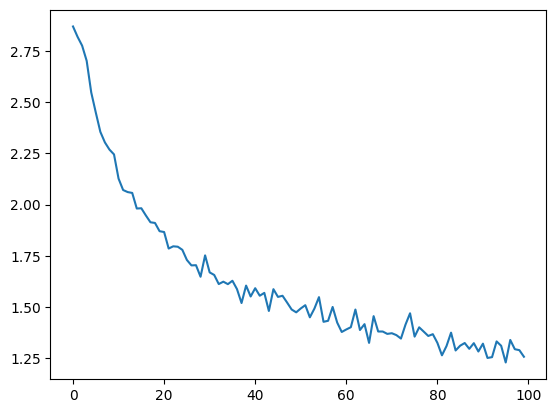

In [ ]:
plt.figure()
plt.plot(all_losses)
plt.show()

In [ ]:
def predict(input_line):
  print(f"> {input_line}")
  with torch.no_grad():
    line_tensor = line_to_tensor(input_line)

    hidden = rnn.init_hidden()

    for i in range(line_tensor.size()[0]):
      output, hidden = rnn.forward(line_tensor[i], hidden)

    guess = category_from_output(output)
    print(guess)

In [ ]:
predict("Raskólnikov")

> Raskólnikov
Russian


In [ ]:
predict("Naruto")

> Naruto
Japanese


In [ ]:
predict("Euler")

> Euler
German
